In [1]:
%load_ext autoreload
%autoreload 2

from preprocessing import oversample_minority_classes
import numpy as np; np.random.seed(0)
from config import OUTPUT_DIR
from util import *
from AL import AL_split, mAP_and_APs, evaluation_dict, AL_resnet16_simulation
import pickle

from config import * 
from util import *
from preprocessing import oversample_minority_classes, build_resnet16
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from scikeras.wrappers import KerasClassifier
from modAL import ActiveLearner
import pickle
from tensorflow import keras
import keras_cv
from keras import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

from util import MULTICLASS_LABELS
from sklearn.metrics import average_precision_score


2024-10-02 07:22:46.302201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 07:22:46.302237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 07:22:46.303466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 07:22:46.310275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 07:22:47.839586: W tensorflow/comp

In [2]:
X = np.load(INTERMEDIATE / 'logmel_multiclass_noise.npy')
Y = np.load(INTERMEDIATE / 'logmel_labels_multiclass_noise.npy')

In [ ]:
# def entropy_sampling(classifier, X_unlabelled, n_instances, X_labeled=None):
#     probabilities = classifier.predict_proba(X_unlabelled, batch_size=32, verbose=2)
#     entropy_values = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)
#     uncertain_indices = np.argsort(entropy_values)[-n_instances:]
#     return uncertain_indices, X_unlabelled[uncertain_indices]



working_dir=OUTPUT_DIR / 'AL' / 'Entropy_300_0.3_' 
identity='Entropy_300_0.3_'
budget_cap=0.3
n_queries=20
oversample=True
batch=32
model_file=MODEL_DIR / 'init_trained.keras'


working_dir.mkdir(exist_ok=True)

# split data
init, pool, test = AL_split(X, Y)
initial_X, initial_Y = init
pool_X, pool_Y = pool
test_X, test_Y = test
currently_labelled = len(initial_X)
initial_ds_size = currently_labelled + len(pool_X)

# duplication oversampling
if oversample:
    initial_X, initial_Y = oversample_minority_classes(initial_X, initial_Y)
    pool_X, pool_Y = oversample_minority_classes(pool_X, pool_Y)
    import gc; gc.collect()

# assume init data has already been fitted
import keras
model = keras.saving.load_model(model_file)
classifier = KerasClassifier(model, batch_size=batch, verbose=2, random_state=0, warm_start=True)

# modAL
learner = ActiveLearner(
    estimator=classifier,
    verbose=2,
    # query_strategy=entropy_sampling 
)

classifier.fit(initial_X[0:1], initial_Y[0:1], epochs=1) # complains if i dont fit something

query_size = int(((pool_X.shape[0] + initial_X.shape[0]) * budget_cap) / n_queries)
print(f'query size: {query_size}')
LB_metrics = []

# keep track of labbelled instances
labeled_X, labeled_Y = initial_X, initial_Y

# active learning loop
for idx in tqdm(range(n_queries)):
    print(f'Query no. {idx + 1}/{n_queries}')

    # query for instances
    query_indicies, query_instances = learner.query(
        pool_X, n_instances=query_size) # labeled_X=labeled_X
    
    # train on instances
    learner.teach(
        X=pool_X[query_indicies], y=pool_Y[query_indicies], 
        only_new=True, verbose=2)

    # get evaluation metrics
    print("evaluating ..")
    currently_labelled += query_size
    labelling_budget = currently_labelled / initial_ds_size 
    pred_Y = classifier.predict_proba(test_X, batch_size=batch, verbose=2)
    LB_metrics.append(
        (labelling_budget, evaluation_dict(pred_Y, test_Y)))


     # keep track of labelled instances
    # labeled_X = np.vstack((labeled_X, pool_X[query_indicies]))
    # labeled_Y = np.vstack((labeled_Y, pool_Y[query_indicies]))
    
    # remove queried instance from pool using index method
    mask = np.ones(len(pool_X), dtype=bool)
    mask[query_indicies] = False
    pool_X = pool_X[mask]
    pool_Y = pool_Y[mask]
        
    # store metrics
    with open(working_dir / 'metrics_overwrite_pkl', 'wb') as f:
        pickle.dump(LB_metrics, f)

# save all metrics and diagrams
pred_Y = classifier.predict_proba(test_X, batch_size=batch, verbose=2)
save_metrics(LB_metrics, working_dir, identity, pred_Y, test_Y)

print("reamining instances: ", pool_X.shape, pool_Y.shape)


1/1 - 4s - 4s/step - auc_pr: 1.0000 - loss: 1.5663e-05 - precision_1: 1.0000 - recall_1: 1.0000
query size: 2555


  0%|                                                                                                              | 0/20 [00:00<?, ?it/s]

Query no. 1/20


2024-10-02 07:23:27.262563: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2332993760 exceeds 10% of free system memory.
2024-10-02 07:23:28.874481: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2332993760 exceeds 10% of free system memory.


4259/4259 - 60s - 14ms/step


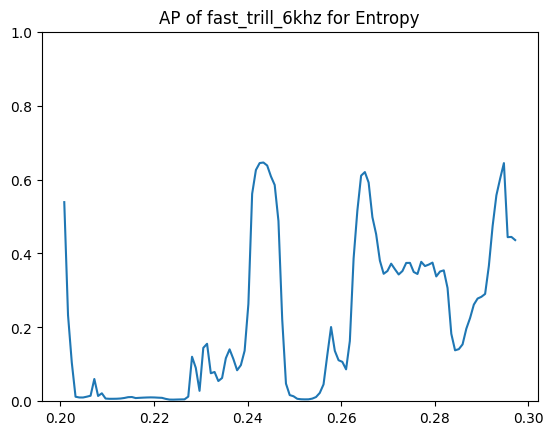

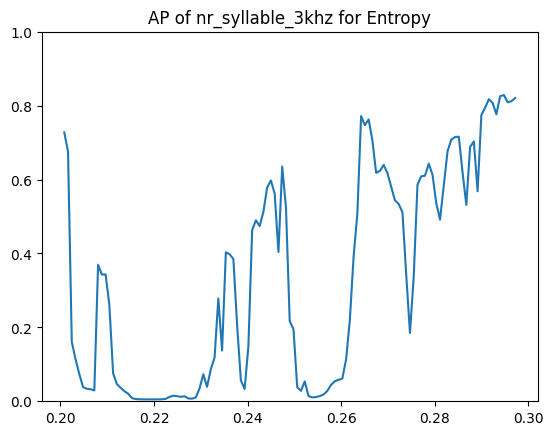

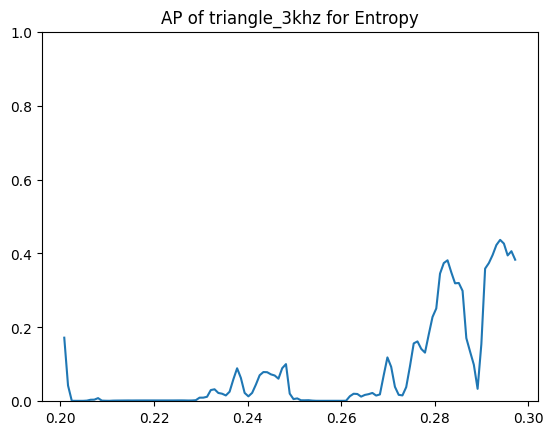

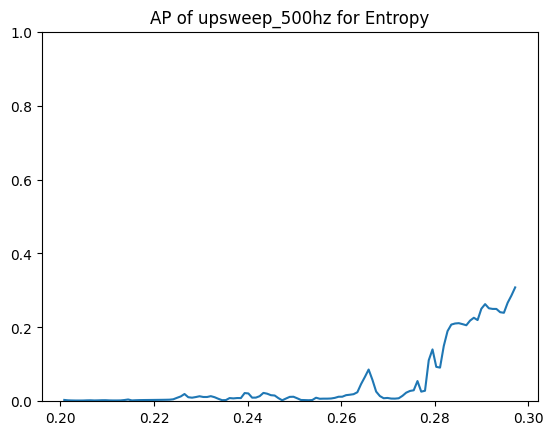

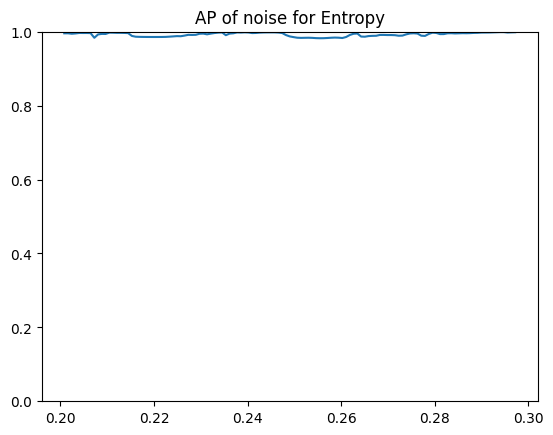

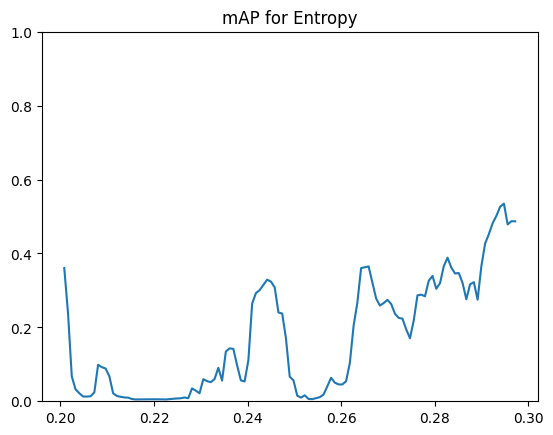

In [2]:
# check LB_metrics again
with open(OUTPUT_DIR / 'AL' / 'Entropy_300_0.3_' / 'metrics_overwrite_pkl', 'rb') as f:
        LB_metrics = pickle.load(f)
    
from AL import save_metrics
wd = OUTPUT_DIR / 'AL' / 'Entropy'
save_metrics(LB_metrics, working_dir=wd, identity='Entropy')